## Overview

This notebook will take a look at agaricus dataset (Mushroom Database) originally drawn from The Audubon Society Field Guide to North American Mushrooms and hosted in the UCI Machine Learning Repository. 

The goal is to create model that can accurately differentiate between edible and poisonous mushrooms.

To do this two models will be used:
* sklearn's RandomForestClassifer
* XGBoost's XGBClassifier

Each model will be used on both a simple numeric mapping and a one-hot encoding of the dataset. In addition to model performance, feature importances will be examined for each model and decision trees built when possible.

Finally, well use investigate each model further using: 
* Permutation Importance
* LIME
* SHAP

to fully understand feature contributions.

In [1]:
import itertools
from collections import Counter
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder,LabelBinarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import Image, HTML, display_html
from sklearn import tree
import pydotplus
import eli5
from eli5.sklearn import PermutationImportance
import shap
import lime
import statsmodels.api as sm
import scipy.stats as ss

In [2]:
RS = 404 # global random state/seed to use
pd.set_option('max_columns',25)
shap.initjs()

## Data

The dataset may be obtained from:

https://archive.ics.uci.edu/ml/datasets/mushroom or https://www.kaggle.com/uciml/mushroom-classification

Additionally, a dataset is used from the XGBoost repository which can be found here:<br>
https://github.com/dmlc/xgboost/tree/master/demo/data


The Kaggle link is preferred simply for convenience as the columns have already been labeled with sensible names.


This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one.

Each entry in dataset contains only a single letter, a reference table containing corresponding meanings can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names

Or in the list shown here:

- **class** : [edible=e, poisonous=p]
- **cap-shape** : [bell=b, conical=c, convex=x, flat=f,  knobbed=k, sunken=s]
- **cap-surface** : [fibrous=f, grooves=g, scaly=y, smooth=s]
- **cap-color** : [brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
- **bruises** : [bruises=t, no=f]
- **odor** : [almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s]
- **gill-attachment** : [attached=a,  descending=d,  free=f,  notched=n]
- **gill-spacing** : [close=c, crowded=w, distant=d]
- **gill-size** : [broad=b, narrow=n]
- **gill-color** : [black=k, brown=n, buff=b, chocolate=h, gray=g,  green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y]
- **stalk-shape** : [enlarging=e, tapering=t]
- **stalk-root** : [bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?]
- **stalk-surface-above-ring** : [fibrous=f, scaly=y, silky=k, smooth=s]
- **stalk-surface-below-ring** : [fibrous=f, scaly=y, silky=k, smooth=s]
- **stalk-color-above-ring** : [brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y]
- **stalk-color-below-ring** : [brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y]
- **veil-type** : [partial=p, universal=u]
- **veil-color** : [brown=n, orange=o, white=w, yellow=y]
- **ring-number** : [none=n, one=o, two=t]
- **ring-type** : [cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z]
- **spore-print-color** : [black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y]
- **population** : [abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y]
- **habitat** : [grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d]

UCI Machine Learning Repository data:

    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data

XGBoost data:

    !wget https://raw.githubusercontent.com/dmlc/xgboost/master/demo/data/agaricus.txt.train
    !wget https://raw.githubusercontent.com/dmlc/xgboost/master/demo/data/agaricus.txt.test
    !wget https://raw.githubusercontent.com/dmlc/xgboost/master/demo/data/featmap.txt


In [3]:
agar = pd.read_csv('data/mushrooms.csv',dtype='category')
# replace dash with underscore for dot access
agar.columns = agar.columns.str.replace('-','_')
# class is python reserved keyword, also impedes dot access
agar.rename(columns={'class':'toxic'},inplace=True)

In [4]:
agar.head()

toxic cap_shape cap_surface cap_color bruises odor gill_attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill_spacing gill_size gill_color stalk_shape stalk_root  \
0            c         n          k           e          e   
1            c         b          k           e          c   
2            c         b          n           e          c   
3            c         n          n           e          e   
4            w         b          k           t          e   

  stalk_surface_above_ring stalk_surface_below_ring stalk_color_above_ring  \
0                        s                        s                      w   
1                        s                        s                      w   
2                        s                        s                      w   
3                        s                        s                      w   
4                        s                        s                      w   

  stalk_color_below_ring veil_type veil_color ring_number ring_type  \
0                      w         p          w           o         p   
1                      w         p          w           o         p   
2                      w         p          w           o         p   
3                      w         p          w           o         p   
4                      w         p          w           o         e   

  spore_print_color population habitat  
0                 k          s       u  
1                 n          n       g  
2                 n          n       m  
3                 k          s       u  
4                 n          a       g

## Exploratory Data Analysis

Short of one variable having with NA values, this dataset is quite clean. It is entirely comprised of categorical values, each with a relatively low cardinality. It is slightly imbalanced, having 4208 (51.8%) entries marked as edible and 3916 (48.2%) marked poisonous, a small discrepancy, but it shouldn't have a significant affect on our model, however.

In [5]:
agar.toxic.value_counts()

e    4208
p    3916
Name: toxic, dtype: int64

In [6]:
agar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
toxic                       8124 non-null category
cap_shape                   8124 non-null category
cap_surface                 8124 non-null category
cap_color                   8124 non-null category
bruises                     8124 non-null category
odor                        8124 non-null category
gill_attachment             8124 non-null category
gill_spacing                8124 non-null category
gill_size                   8124 non-null category
gill_color                  8124 non-null category
stalk_shape                 8124 non-null category
stalk_root                  8124 non-null category
stalk_surface_above_ring    8124 non-null category
stalk_surface_below_ring    8124 non-null category
stalk_color_above_ring      8124 non-null category
stalk_color_below_ring      8124 non-null category
veil_type                   8124 non-null category
veil_color                

At first glance, it appears as though there are no NA values but from reading the data description we know that `stalk_root` does have null values, they are just labeled with a '?'

In [7]:
agar.stalk_root.value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk_root, dtype: int64

Since there is only one variable with any missing values and we are about to encode everything anyway, there is no point in replacing it with np.nan

In [8]:
agar.nunique().sort_values(ascending=False)

gill_color                  12
cap_color                   10
spore_print_color            9
odor                         9
stalk_color_below_ring       9
stalk_color_above_ring       9
habitat                      7
population                   6
cap_shape                    6
stalk_root                   5
ring_type                    5
stalk_surface_above_ring     4
stalk_surface_below_ring     4
veil_color                   4
cap_surface                  4
ring_number                  3
stalk_shape                  2
gill_size                    2
gill_spacing                 2
gill_attachment              2
bruises                      2
toxic                        2
veil_type                    1
dtype: int64

`veil_type` only has 1 entry, so it adds no information to our model and can be safely dropped.

In [9]:
agar_enc = agar.drop(columns='veil_type').apply(lambda x: x.cat.codes)

In [10]:
X, y = agar.drop(columns=['toxic','veil_type']), agar.toxic
X_enc, y_enc = X.apply(lambda x: x.cat.codes), y.cat.codes # numericize

In [11]:
# categorical encoded dataset
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=.20, random_state=RS)

In [12]:
# One-hot encoded dataset
Xoh = pd.get_dummies(X, drop_first=False)
Xoh_train, Xoh_test, yoh_train, yoh_test = train_test_split(Xoh, y_enc, test_size=.20, random_state=RS)
X.shape,Xoh.shape

((8124, 21), (8124, 116))

Using a simple one-hot encoding increases the feature count to 116, though it makes the data rather sparse, it is not unreasonable in size since we started with only 21 features and a max cardinality of 12.

In [13]:
Xoh.head()

cap_shape_b  cap_shape_c  cap_shape_f  cap_shape_k  cap_shape_s  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cap_shape_x  cap_surface_f  cap_surface_g  cap_surface_s  cap_surface_y  \
0            1              0              0              1              0   
1            1              0              0              1              0   
2            0              0              0              1              0   
3            1              0              0              0              1   
4            1              0              0              1              0   

   cap_color_b  cap_color_c  ...  population_c  population_n  population_s  \
0            0            0  ...             0             0             1   
1            0            0  ...             0             1             0   
2            0            0  ...             0             1             0   
3            0            0  ...             0             0             1   
4            0            0  ...             0             0             0   

   population_v  population_y  habitat_d  habitat_g  habitat_l  habitat_m  \
0             0             0          0          0          0          0   
1             0             0          0          1          0          0   
2             0             0          0          0          0          1   
3             0             0          0          0          0          0   
4             0             0          0          1          0          0   

   habitat_p  habitat_u  habitat_w  
0          0          1          0  
1          0          0          0  
2          0          0          0  
3          0          1          0  
4          0          0          0  

[5 rows x 116 columns]

In [14]:
ftnames = X.columns.values # feature names
ftnames_oh = Xoh.columns.values # One-hot encoded feature names

In [15]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://github.com/shakedzy/dython
def conditional_entropy(x, y):
    """Calculates the conditional entropy of x given y: S(x|y)

    Parameters
    ----------
    x,y : array-like, int-encoded categorical value arrays
    
    Returns
    -------
    entropy : float
    
    See Also
    --------
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    
    """
    y=y.astype(np.int64)
    y_counter = np.bincount(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = y_counter.sum()
    entropy = 0.0
    for k,v in xy_counter.items():
        p_xy = v / total_occurrences
        p_y = y_counter[k[1]] / total_occurrences
        entropy += p_xy * np.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)

    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
        
    Returns 
    -------
    float, between range [0,1]
    
    See Also
    --------
    Original function from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    
def theils_u(x, y):
    """Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
   
    This is the uncertainty of x given y: value is on the range of [0,1] 
    - where 0 means y provides no information about x, 
    and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    
    Parameters
    ----------
    x,y : array-like, int-encoded categorical value arrays
    
    Returns
    -------
    uncertainity coefficent : float between [0,1]
    
    See Also
    --------
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    """
    x=x.astype(np.int64)
    s_xy = conditional_entropy(x,y)
    x_counter = np.bincount(x)
    total_occurrences = x_counter.sum()
    p_x = x_counter/total_occurrences
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    return (s_x - s_xy) / s_x

def catcorr(data, method='theils'):
    """ Compute categorical correlations using uncertainty coefficients (Theil's U) or Cramer's V
    
    Parameters
    ----------
    data : pandas.DataFrame 
        dataset used to compute correlations 
    method - str, ['theils' | 'cramers']
        method to calculate correlations, cramers is symmetric, theils is asymmetric
    
    Returns
    -------
        computed correlations : pandas.DataFrame
    """
    if method == 'cramers':
        return data.corr(method=cramers_v)
    elif method != 'theils':
        raise NotImplementedError(f"method: '{method}' not implemented, choose either 'cramers' or 'theils'")
    cols = data.columns
    clen = cols.size
    
    pairings = list(itertools.product(data.columns, repeat=2))
    theils_mat = np.reshape([theils_u(data[p[1]],data[p[0]]) for p in pairings],(clen,clen))
    return pd.DataFrame(theils_mat, index=cols, columns=cols)

Since we are working with all categorical values a traditional correlation matrix will not suffice. Instead, we'll be using an [uncertainty coefficient](https://en.wikipedia.org/wiki/Uncertainty_coefficient) matrix to model the asymmetric relationships between value pairs. The functions used are slight modifications of those in the [dython package](https://github.com/shakedzy/dython), modified to prefer performance over flexibility.

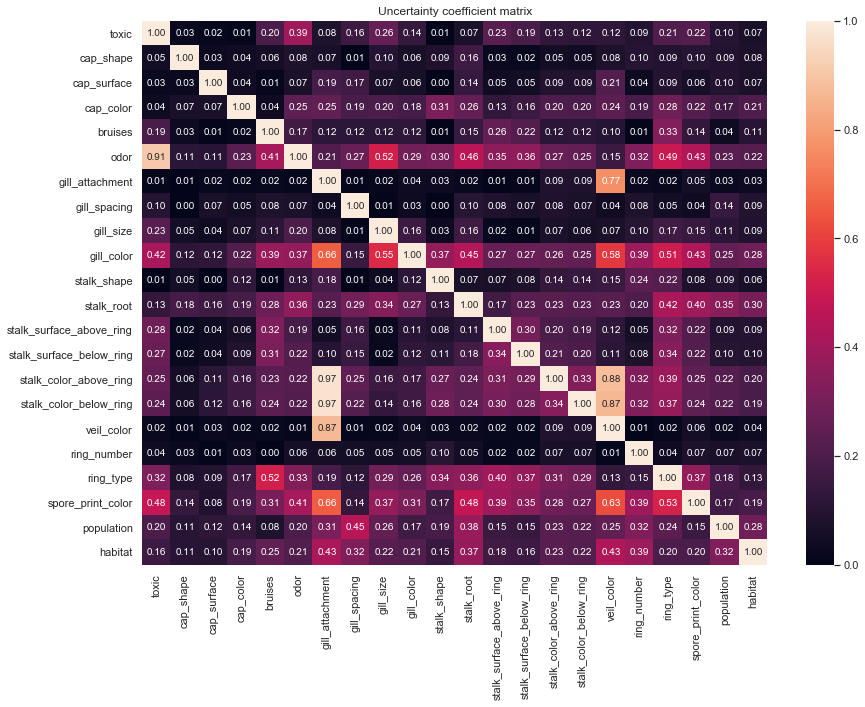

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(catcorr(agar_enc),0,1,ax=ax,annot=True,fmt="0.2f").set_title("Uncertainty coefficient matrix")
plt.show()

The matrix reveals a few key findings, first and foremost, given we know `odor` we already have a substantial amount of information pertaining to the response, `toxic`. This will be very important to keep in mind as a we move forward with the analysis. 

Additional there is a near symmetric relationship among `veil_color` and the `stalk_color*` features, this relationship is not true across all color attributes, however, as seen by `spore_print_color`, `gill_print_color`, and `cap_color`.

## Models

We'll be using two primary models
- RandomForestClassifier - sklearn
- XGBoostClassifier - XGBoost

We will run both the categorical encoded and one-hot encoded data on each of these classifiers.

#### Helper functions

In [17]:
def multi_table(*dfs):
    """Compactly display multiple adjacent DataFrames
    
    Args: *dfs, pd.DataFrames
    See also: https://stackoverflow.com/a/44923103
    """
    html_str=''
    for df in dfs:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [18]:
def pplot_cm(y_true, y_pred, labels=None, filename=None, ymap=None, cf_report=False, figsize=(7,5), **kwargs):
    """
    Pretty plot a confusion matrix with annotations.
    Optionally save plot image to disk.
    
    Args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    array of shape [n_class,] name the order of class labels in the confusion matrix.
                 If None, defaults to y_true.unique()
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      cf_report: if True, print a classification report in addition to confusion matrix
      figsize:   the size of the figure plotted.
      **kwargs:  keyword arguments to pass to seaborn's heatmap
      
    See also:
        https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    if cf_report: 
        print(classification_report(y_true,y_pred))
    labels=labels if labels is not None else y_true.unique()
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, **kwargs)
    plt.savefig(filename) if filename is not None else plt.show()

In [19]:
def plot_tree(dtree, featnames, cnames=None, width=600, height=800):
    """Plot a decision tree using graphviz, pydotplus and IPython.Image
    
    Args:
        dtree : fitted DecisionTree
        featnames : array-like[str], feature names to label tree nodes
        cnames : array-like[str], class names to label tree nodes (default: None)
        width : int, width(in px) of output visualization
        height : int, height(in px) of output visualization
    Returns: 
        tree plot : IPython.Image
    See also:
        https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
    """
    dot_data = StringIO()
    tree.export_graphviz(dtree, out_file=dot_data, 
                    feature_names=featnames, class_names=cnames,
                    filled=True, rounded=True, special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png(), width=width, height=height)

### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       840
           1       1.00      1.00      1.00       785

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



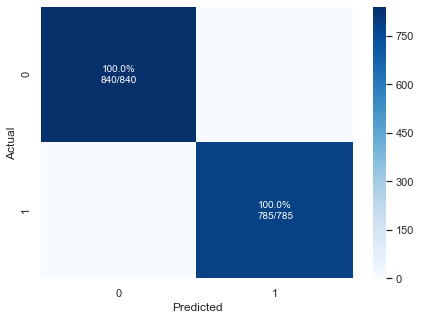

In [20]:
rfc = RandomForestClassifier(100 ,n_jobs=-1, random_state=RS)
rfc.fit(X_train,y_train)
preds = rfc.predict(X_test)
pplot_cm(y_test, preds, rfc.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

Our Random Forest model yielded perfect scores across the board. Now, this may seem like fantastic news, but anytime you have a perfectly performing model it should be met with a great deal of skepticism. The majority of the time, it means there is either data leakage somewhere in the dataset or some mistake made during modeling or data prep. Perhaps testing data was accidentally introduced during training, or one of the input variables is perfectly correlated with the target, or maybe the chosen train/test split just happened to pick an easy subset.

From the uncertainty coefficients matrix, we know that there is no perfect correlation between any variables and the target, and there does not appear to be any overlap between train and test data. So, we'll see if luck was the answer by doing k-fold validation.

In [21]:
skf = StratifiedKFold(5, shuffle=True, random_state=RS)
for train_idx, test_idx in skf.split(X_enc, y_enc):
    X_train, X_test, y_train, y_test = X_enc.loc[train_idx], X_enc.loc[test_idx], y_enc[train_idx], y_enc[test_idx]
    rfc.fit(X_train,y_train)
    y_pred = rfc.predict(X_test)
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       784

    accuracy                           1.00      1626
   macro avg       1.00      1.00      1.00      1626
weighted avg       1.00      1.00      1.00      1626

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

              preci

Perfect across 5 folds, let's see how it does with 10.

In [22]:
metrics = ['precision','recall','f1','roc_auc']
scores = cross_validate(rfc, X_enc, y_enc, scoring=metrics, cv=10, return_train_score=True, n_jobs=-1)

for m in metrics:
    test_score, train_score = [scores[x] for x in scores.keys() if m in x]
    print(m+':\n','{:>4} train scores: {}'.format('',list(train_score)))
    print('{:>5} test scores: {}'.format('',list(test_score)))
    print('{:>5} test mean: {}'.format('',test_score.mean()))

precision:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9678217821782178, 1.0]
      test mean: 0.9967821782178218
recall:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [0.3469387755102041, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test mean: 0.9346938775510203
f1:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [0.5151515151515151, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9836477987421384, 1.0]
      test mean: 0.9498799313893654
roc_auc:
      train scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
      test mean: 1.0


It does indeed appear as though some subsets of the data were easier to predict than others but on the whole, we still have a very strong classifier, well above 90% on all metrics using 10-fold cross_validation.

This is with no tweaks to the model's hyperparameters at all, just the defaults. With a bit of tweaking near perfect predictions isn't out of the realm of possibility.

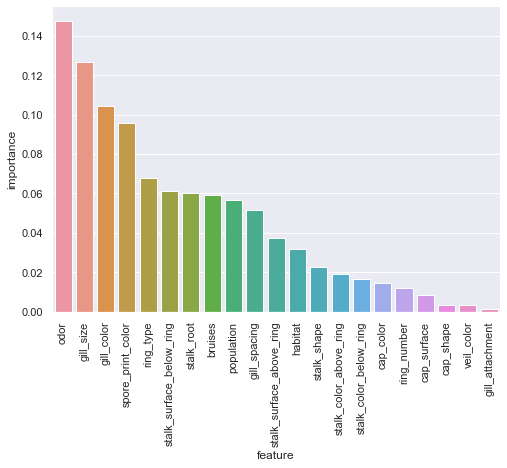

In [23]:
rfc_fi = pd.DataFrame({'feature':X.columns,'importance':rfc.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=rfc_fi,kind='bar',aspect=1.5).set_xticklabels(rotation=90);

`odor`, `gill_size`, `gill_color`, and `spore_print_color` encapsulate a large portion of the overall feature importance for the RandomForest model. Odor makes some intuitive sense even with no fungal knowledge. Generally, smell is a fairly strong indicator of whether or not something is safe to consume. Of course, given how we have chosen to represent the data, we do not have the level of detail required to know exactly what kind of smell means edible or poisonous.

In [24]:
# filter out any non-perfect scoring decision trees, then take tree with fewest leaves 
smallest_dt = min(filter(lambda dt: dt.score(X_test, y_test) == 1.0, rfc.estimators_), key=lambda dt: dt.get_n_leaves())

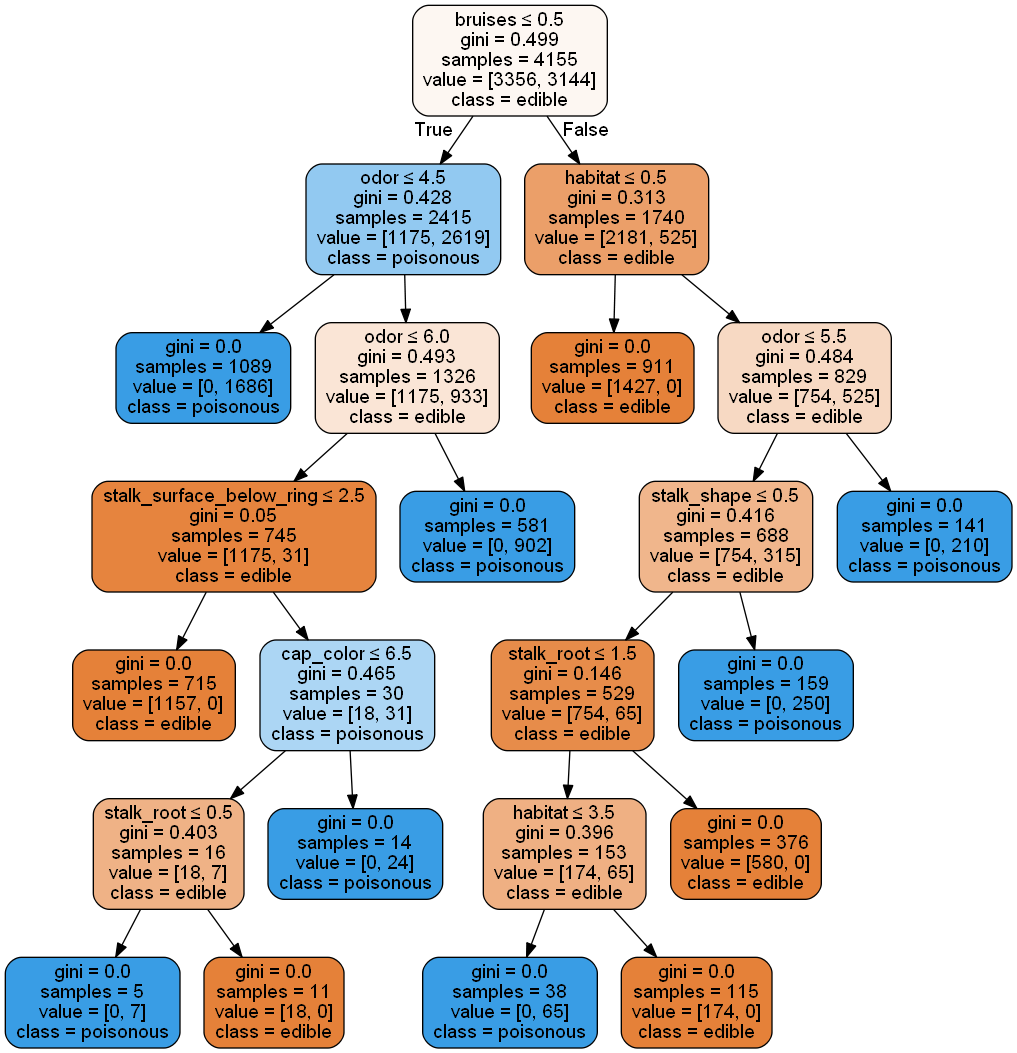

In [25]:
plot_tree(smallest_dt, ftnames, ['edible','poisonous'],500,600)

Reducing the random forest to a single decision tree gives some insight into the model's decision making process. However, it is not quite intuitive from a human rationalization standpoint. Next, we'll try using the one-hot encoded data to see if increased granularity provides easier interpretations.

#### One hot encoded

In [26]:
rfc_oh = RandomForestClassifier(100, n_jobs=-1,random_state=RS)
rfc_oh.fit(Xoh_train,yoh_train)
preds_oh = rfc_oh.predict(Xoh_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       840
           1       1.00      1.00      1.00       785

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



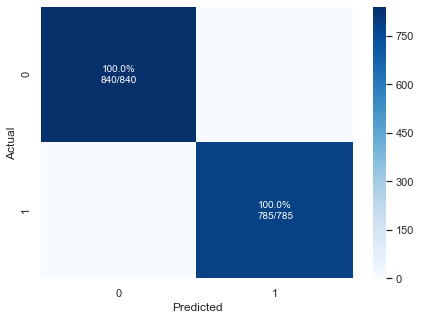

In [27]:
pplot_cm(yoh_test, preds_oh, rfc_oh.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

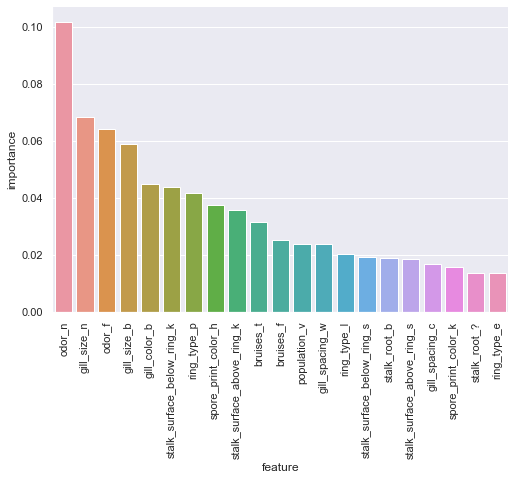

In [28]:
rfc_oh_fi = pd.DataFrame({'feature':Xoh.columns,'importance':rfc_oh.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=rfc_oh_fi[:21],kind='bar',aspect=1.5).set_xticklabels(rotation=90);

`odor`=none and `odor`=foul rank 1st and 3rd for feature importance with `gill_size`=narrow coming between. One may speculate that having no perceptible odor would indicate it may be safe for consumption.

In [29]:
odorXtox = pd.crosstab(agar.odor, agar.toxic)
gsizXtox = pd.crosstab(agar.gill_size, agar.toxic)
gcolXtox = pd.crosstab(agar.gill_color, agar.toxic)
multi_table(odorXtox,gsizXtox,gcolXtox)

toxic 
 e 
 p 
 
 
 odor 
 
 
 
 
 
 
 a 
 400 
 0 
 
 
 c 
 0 
 192 
 
 
 f 
 0 
 2160 
 
 
 l 
 400 
 0 
 
 
 m 
 0 
 36 
 
 
 n 
 3408 
 120 
 
 
 p 
 0 
 256 
 
 
 s 
 0 
 576 
 
 
 y 
 0 
 576 
 
 
 
 
 
 toxic 
 e 
 p 
 
 
 gill_size 
 
 
 
 
 
 
 b 
 3920 
 1692 
 
 
 n 
 288 
 2224 
 
 
 
 
 
 toxic 
 e 
 p 
 
 
 gill_color 
 
 
 
 
 
 
 b 
 0 
 1728 
 
 
 e 
 96 
 0 
 
 
 g 
 248 
 504 
 
 
 h 
 204 
 528 
 
 
 k 
 344 
 64 
 
 
 n 
 936 
 112 
 
 
 o 
 64 
 0 
 
 
 p 
 852 
 640 
 
 
 r 
 0 
 24 
 
 
 u 
 444 
 48 
 
 
 w 
 956 
 246 
 
 
 y 
 64 
 22

A quick crosstab reveals that there are 120 cases were mushroom with no odor is still poisonous, and in fact, **`odor=none` is the only odor value without perfect dichotomous separability**. Gill size is slightly less absolute in claims, but having a narrow size is a rather strong indication of it being inedible. As for color, the only attribute with substantial support is when `gill_color` = <span style='color:#E0AB76'>buff</span>

In [30]:
smallest_dt_oh = min(filter(lambda dt: dt.score(Xoh_test, yoh_test) == 1.0, rfc_oh.estimators_), key=lambda dt: dt.get_n_leaves())

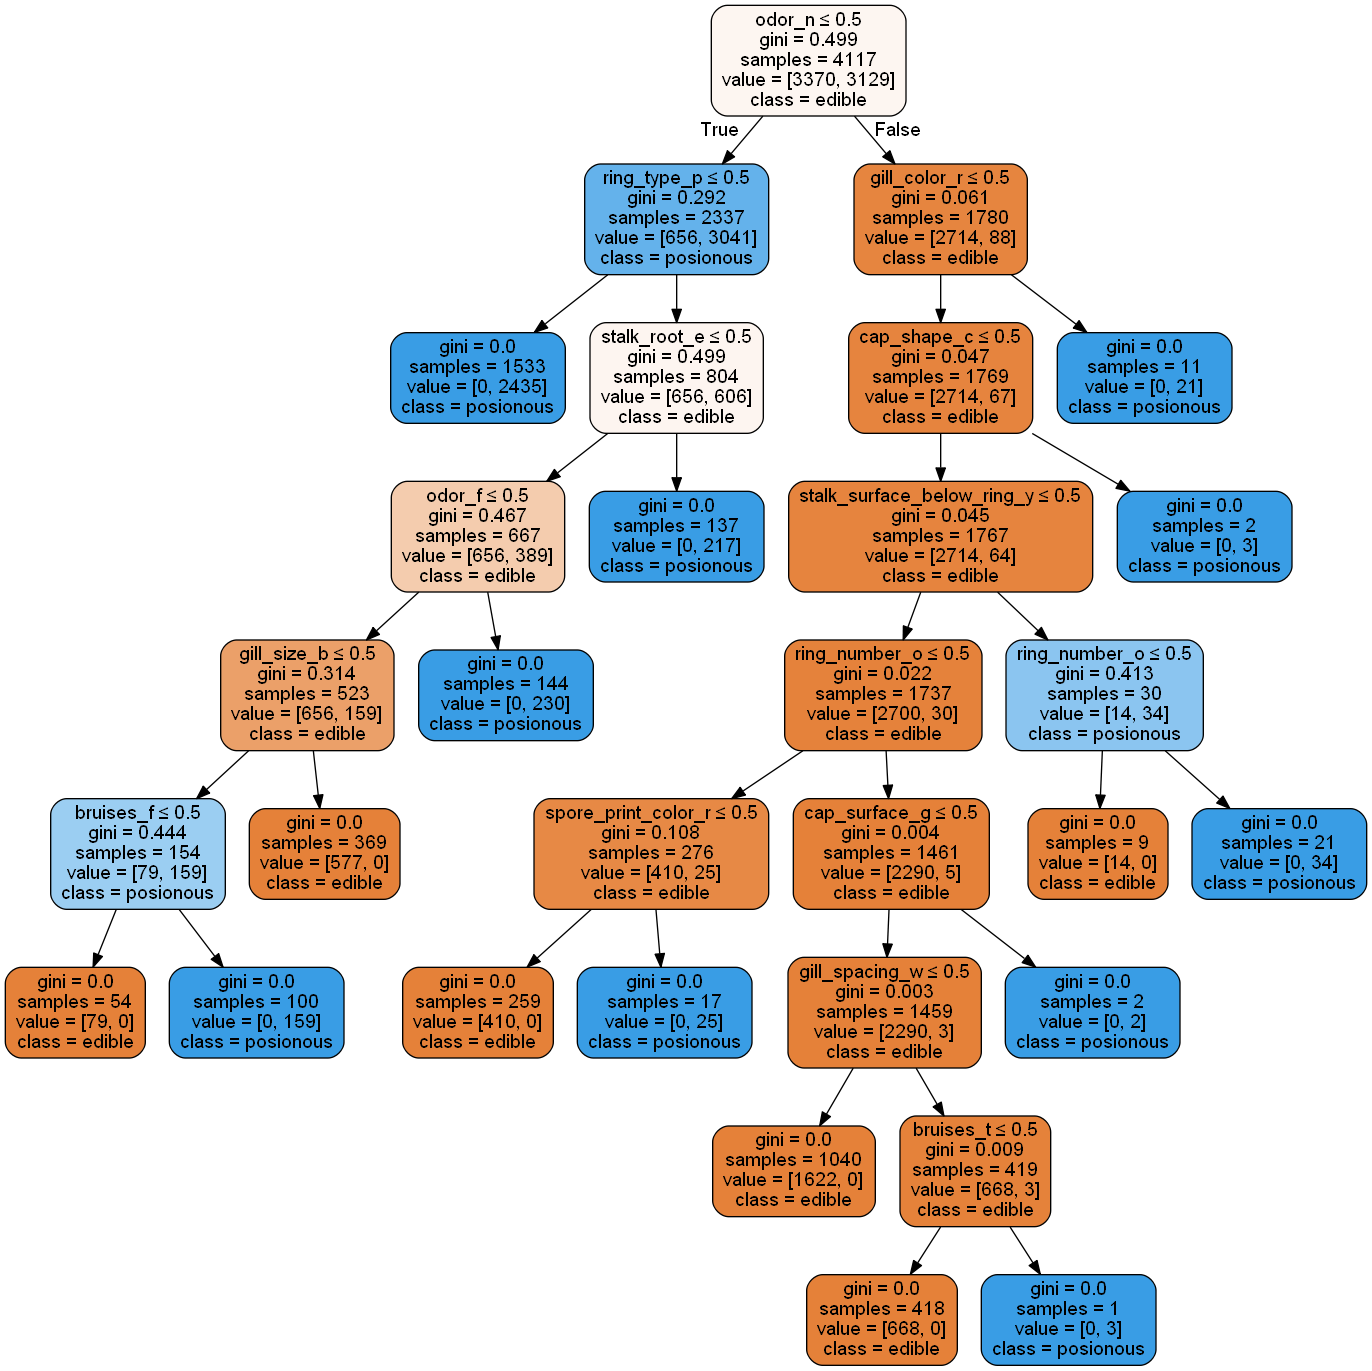

In [31]:
plot_tree(smallest_dt_oh, ftnames_oh, ['edible','posionous'])

### XGBoost

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       841
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1624
   macro avg       1.00      1.00      1.00      1624
weighted avg       1.00      1.00      1.00      1624



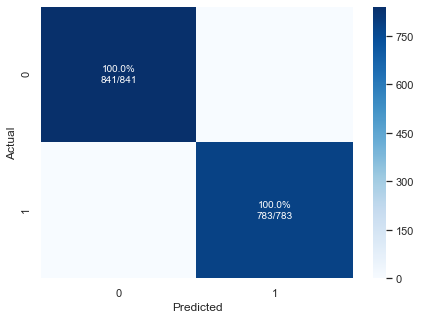

In [32]:
xgbc = xgb.XGBClassifier(n_jobs=-1,random_state=RS)
xgbc.fit(X_train,y_train)
preds = xgbc.predict(X_test)
pplot_cm(y_test, preds, xgbc.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

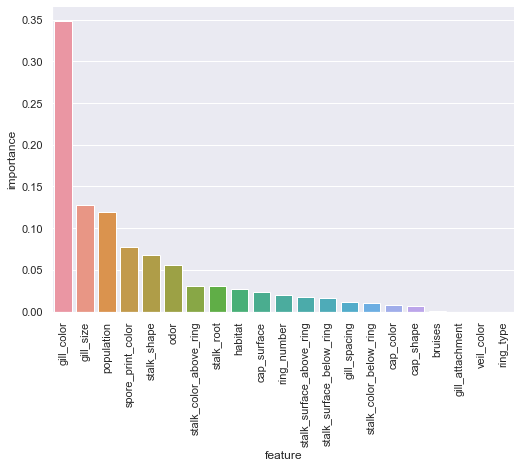

In [33]:
xgbc_fi = pd.DataFrame({'feature':X.columns,'importance':xgbc.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=xgbc_fi,kind='bar',aspect=1.5).set_xticklabels(rotation=90);

In stark contrast with the random forest model, `gill_color` is by far the most important feature to the XGBoost model. Population also now appears in the top 3, just trailing `gill_size`

#### One-hot encoding

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       840
           1       1.00      1.00      1.00       785

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



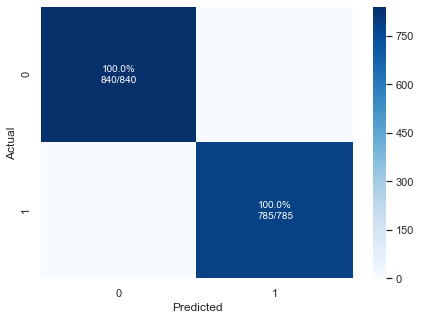

In [34]:
xgbc_oh = xgb.XGBClassifier(n_jobs=-1,random_state=RS)
xgbc_oh.fit(Xoh_train,yoh_train)
preds = xgbc_oh.predict(Xoh_test)
pplot_cm(yoh_test, preds, xgbc_oh.classes_, cf_report=True, figsize=(7,5), cmap='Blues')

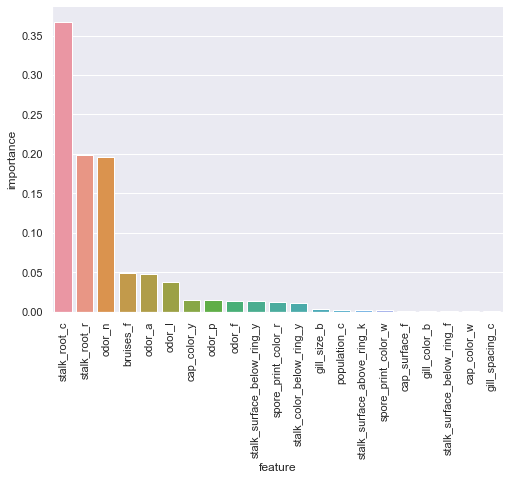

In [35]:
xgbc_oh_fi = pd.DataFrame({'feature':Xoh.columns,'importance':xgbc_oh.feature_importances_}).sort_values(by='importance',ascending=False)
sns.catplot(x='feature',y='importance',data=xgbc_oh_fi[:21],kind='bar',aspect=1.5).set_xticklabels(rotation=90);

The one-hot encoded feature importance is wildly different than any previous model importances, now claiming `stalk_root_c` as the more important feature and quickly tapering off after only 3 features.

#### XGBoost with DMatrix

Since XGBoost uses this dataset in its official [Get Started with XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html) tutorial, it's worth briefly mentioning here.

Another approach to using XGBoost using LibSVM formatted data. It is an extremely lightweight way to encode sparse data and has greatly improved performance, albeit at the cost of some degree of interpretability. Data is represented in a newline delimited file where each line is a data sample formated as `<target> <feat1_idx>:<feat1_val> <feat9_idx>:<feat9_val> ...`

Additional reading:
* https://xgboost.readthedocs.io/en/latest/tutorials/input_format.html#basic-input-format
* https://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#/Q03:_Data_preparation
* https://stats.stackexchange.com/questions/61328/libsvm-data-format

In [36]:
# read in data
dtrain = xgb.DMatrix('data/agaricus.txt.train')
dtest = xgb.DMatrix('data/agaricus.txt.test')
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

[19:51:47] 6513x127 matrix with 143286 entries loaded from data/agaricus.txt.train
[19:51:47] 1611x127 matrix with 35442 entries loaded from data/agaricus.txt.test


In [37]:
bst.get_fscore('data/featmap.txt') # feature importances as weight

{'odor=pungent': 2,
 'stalk-root=cup': 1,
 'spore-print-color=orange': 1,
 'stalk-root=missing': 1}

`get_fscore()` uses a simple split count to determine feature importance, referred to as 'weight'. To more closely resemble the underlying method used by sklearn's RandomForest, we can instead use 'gain' in combination with `get_score()`

In [38]:
bst.get_score('data/featmap.txt', importance_type='gain')

{'odor=pungent': 2285.1280540000002,
 'stalk-root=cup': 1158.21204,
 'spore-print-color=orange': 198.173828,
 'stalk-root=missing': 832.545044}

## Model Exploration

Despite plotting out decision trees and feature importances for given data and one-hot encoded data, we still cannot definitively say exactly why our models were able to achieve perfect classification. Unless we can be certain as to what exactly contributes to our perfect classifiers, we cannot eliminate the possibility that we have made a mistake somewhere.

Let's begin by taking another look at those feature importance calculations to see why these alone aren't enough to make any definitive claims.

In [39]:
# Define a random index to use across all intrepretation methods
np.random.seed(RS)
RNIDX = np.random.choice(X_test.index) # Random index from test dataset 
posidx = X_test.index.get_loc(RNIDX) # positional index within the test dataset of the index label
print(f"Index label (full=split): {RNIDX}\nPostional index (X_test): {posidx}")
(X_enc.loc[RNIDX] == X_test.iloc[posidx]).all()

Index label (full=split): 6027
Postional index (X_test): 1206


True

In [40]:
fi_merge = rfc_fi.merge(xgbc_fi, on='feature',suffixes=('_rf', '_xgb')).set_index('feature')
# One-hot encoded feature importances
fi_oh_merge = rfc_oh_fi.merge(xgbc_oh_fi, on='feature',suffixes=('_rf', '_xgb')).set_index('feature')
# Uncertainty coefficients
unc_coef = X_enc.corrwith(y_enc,method=theils_u).sort_values(ascending=False)
unc_coef_oh = Xoh.corrwith(y_enc,method=theils_u).sort_values(ascending=False)

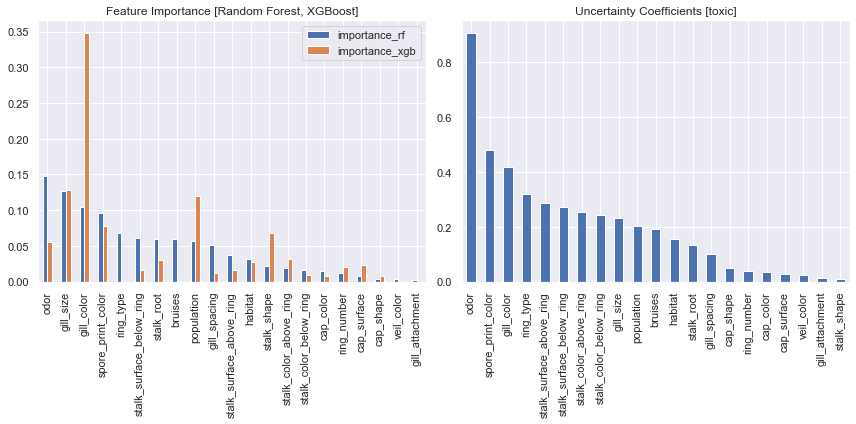

In [41]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
fi_merge.plot.bar(ax=axs[0])
unc_coef.plot.bar(ax=axs[1])
axs[0].set_xlabel(None)
axs[0].set_title('Feature Importance [Random Forest, XGBoost]')
axs[1].set_title('Uncertainty Coefficients [toxic]')
plt.tight_layout()
plt.show()

Plot the importance values side by side and the issue becomes quite apparent, the models simply do not agree on which features are most important. The random forest agrees with the uncertain coefficient values in stating the a relationship between `odor` and `toxic`, but the XGBoost model has determined `gill_color` to be substantially more important.

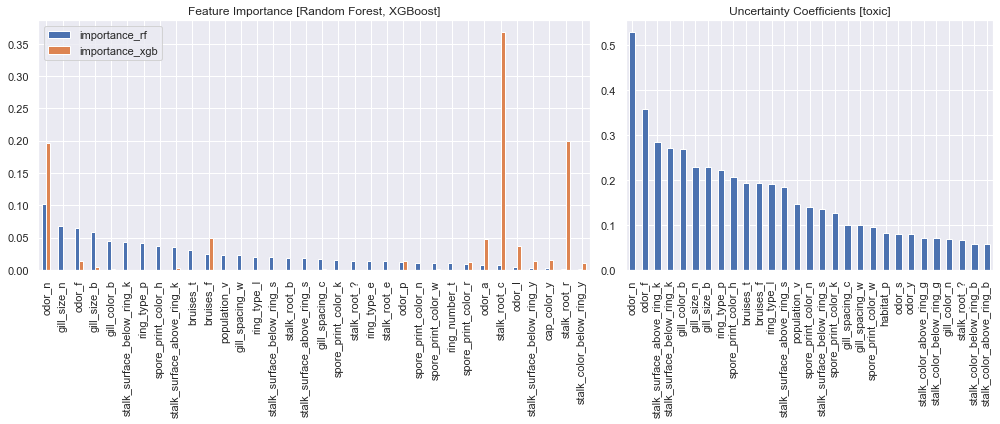

In [42]:
fig,axs=plt.subplots(1,2,figsize=(14,6),gridspec_kw=dict(width_ratios=[3, 2]))
# filter out features of little importance for plotting
fi_oh_merge.query('importance_rf > 0.01 | importance_xgb > 0.01').plot.bar(ax=axs[0])
# filter out low coefficient values
unc_coef_oh[unc_coef_oh>0.05].plot.bar(ax=axs[1])
axs[0].set_xlabel(None)
axs[0].set_title('Feature Importance [Random Forest, XGBoost]')
axs[1].set_title('Uncertainty Coefficients [toxic]')
plt.tight_layout()
plt.show()

As we previously established, there is even less agreement among the one-hot encoded feature importance. The most import attributes to XGBoost were some of the least important to the random forest model, they also had extremely low uncertainty coefficients. It's clear that we'll need a different means of reaching a consensus between our models.

### Permutation Importance

The goal of permutation importance is to estimate the importance of the features present in a model without requiring the model to be retrained. To do so, we take a trained model and first calculate a baseline prediction score using a testing dataset. Then, each feature is essentially mocked out one by one using random noise in its place. To maintain model assumptions, the same data is used in mocked feature, only now, it has been shuffled. The difference between the baseline and the new score is determined to be that feature's importance. 

In [43]:
def multi_eli5(*explainers):
    """Compactly display multiple adjacent eli5 tables
    
    Args: 
        *explainers:  HTML objects
            HTML objects returned by any eli5.show_* method
    See also: multi_table()
    """
    html_str=''
    for expl in explainers:
        html_str+=expl._repr_html_().replace('style="border-collapse: collapse;','style="display: inline; border-collapse: collapse;')
        
    display_html(html_str,raw=True)

##### Random Forest

In [44]:
rfc_pi = PermutationImportance(rfc, random_state=RS, cv='prefit').fit(X_test, y_test)
rfc_oh_pi = PermutationImportance(rfc_oh, random_state=RS, cv='prefit').fit(Xoh_test, yoh_test)

Using `cv='prefit'` in combination with using a test data set will provide insight into which variables are most important for a models ability to generalize. Setting `cv=None` would refit the model and show permutation importance for retrained model.

In [45]:
rfc_weights = eli5.show_weights(rfc,feature_names=ftnames)
rfc_pi_weights = eli5.show_weights(rfc_pi,feature_names=ftnames)

In [46]:
multi_eli5(rfc_weights,rfc_pi_weights)

Weight 
 Feature 
 
 
 
 
 
 
 0.1474
 
 ± 0.3446
 
 
 
 odor
 
 
 
 
 
 0.1266
 
 ± 0.2447
 
 
 
 gill_size
 
 
 
 
 
 0.1043
 
 ± 0.2815
 
 
 
 gill_color
 
 
 
 
 
 0.0957
 
 ± 0.2257
 
 
 
 spore_print_color
 
 
 
 
 
 0.0676
 
 ± 0.2145
 
 
 
 ring_type
 
 
 
 
 
 0.0613
 
 ± 0.1950
 
 
 
 stalk_surface_below_ring
 
 
 
 
 
 0.0601
 
 ± 0.1452
 
 
 
 stalk_root
 
 
 
 
 
 0.0593
 
 ± 0.1906
 
 
 
 bruises
 
 
 
 
 
 0.0564
 
 ± 0.1615
 
 
 
 population
 
 
 
 
 
 0.0518
 
 ± 0.1677
 
 
 
 gill_spacing
 
 
 
 
 
 0.0372
 
 ± 0.1483
 
 
 
 stalk_surface_above_ring
 
 
 
 
 
 0.0318
 
 ± 0.0628
 
 
 
 habitat
 
 
 
 
 
 0.0224
 
 ± 0.0722
 
 
 
 stalk_shape
 
 
 
 
 
 0.0188
 
 ± 0.0752
 
 
 
 stalk_color_above_ring
 
 
 
 
 
 0.0165
 
 ± 0.0567
 
 
 
 stalk_color_below_ring
 
 
 
 
 
 0.0147
 
 ± 0.0371
 
 
 
 cap_color
 
 
 
 
 
 0.0118
 
 ± 0.0366
 
 
 
 ring_number
 
 
 
 
 
 0.0083
 
 ± 0.0288
 
 
 
 cap_surface
 
 
 
 
 
 0.0035
 
 ± 0.0120
 
 
 
 cap_shape
 
 
 
 
 
 0.0031
 
 ± 0.0220
 
 
 
 veil_color
 
 
 
 
 
 
 
 … 1 more … 
 
 
 
 
 
 
 

 


 

 

 

 

 

 




 



 

 

 

 

 

 


 

 

 

 

 

 


 

 

 

 

 
 
 
 
 Weight 
 Feature 
 
 
 
 
 
 
 0.0179
 
 ± 0.0034
 
 
 
 gill_size
 
 
 
 
 
 0.0025
 
 ± 0.0017
 
 
 
 spore_print_color
 
 
 
 
 
 0.0001
 
 ± 0.0005
 
 
 
 odor
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 cap_surface
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 ring_type
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 ring_number
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 veil_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_color_below_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_color_above_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_surface_below_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_root
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 population
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_shape
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_spacing
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_attachment
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 bruises
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 cap_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_surface_above_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 habitat
 
 
 
 
 
 
 
 … 1 more …

As we can see, the permutation importance weights (right) are dramatically different than the standard model weights. These tables give us an idea of what features are most relevant in the testing set, had we used a larger test size the permutation weights would be more substantial. 

In [47]:
eli5.show_prediction(rfc, X_test.loc[RNIDX], feature_names=ftnames, show_feature_values=True)

With `show_prediction` we now begin to gain local model insights. For a Random Forest, Contributions are calculated by following decision paths of trees in an ensemble. Each node of the tree has an output score, and contribution of a feature on the decision path is how much the score changes from parent to child. The [methods used](http://blog.datadive.net/interpreting-random-forests/) in this implementation are quite similar to those in the [treeinterpreter](https://github.com/andosa/treeinterpreter) package.

In [48]:
eli5.show_prediction(rfc_oh, Xoh.loc[RNIDX], feature_names=ftnames_oh, show_feature_values=True, top=20)

Using the one-hot encoded data provides us with an even more granular explanation of the contributing features. `gill_color` and `gill_size` dominate the dummy encoded data, but the one-hot shows `stalk_surface_below_ring` as the secondary most import feature in calculating this sample.

##### XGBoost

In [49]:
xgbc_pi = PermutationImportance(xgbc, random_state=RS, cv='prefit').fit(X_test,y_test)
xgbc_oh_pi = PermutationImportance(xgbc_oh, random_state=RS, cv='prefit').fit(Xoh_test, yoh_test)

In [50]:
multi_eli5(
    eli5.show_weights(xgbc_pi,feature_names=ftnames),
    eli5.show_weights(xgbc_oh_pi,feature_names=ftnames_oh)
)

Weight 
 Feature 
 
 
 
 
 
 
 0.3371
 
 ± 0.0157
 
 
 
 odor
 
 
 
 
 
 0.0148
 
 ± 0.0008
 
 
 
 spore_print_color
 
 
 
 
 
 0.0042
 
 ± 0.0014
 
 
 
 gill_spacing
 
 
 
 
 
 0.0026
 
 ± 0.0014
 
 
 
 population
 
 
 
 
 
 0.0015
 
 ± 0.0015
 
 
 
 gill_color
 
 
 
 
 
 0.0010
 
 ± 0.0010
 
 
 
 gill_size
 
 
 
 
 
 0.0006
 
 ± 0.0011
 
 
 
 habitat
 
 
 
 
 
 0.0006
 
 ± 0.0000
 
 
 
 stalk_shape
 
 
 
 
 
 0.0001
 
 ± 0.0005
 
 
 
 stalk_surface_above_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 ring_type
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 ring_number
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 veil_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_color_below_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 cap_surface
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_surface_below_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_attachment
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 bruises
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 cap_color
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_color_above_ring
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_root
 
 
 
 
 
 
 
 … 1 more … 
 
 
 
 
 
 
 

 


 

 

 

 

 

 




 



 

 

 

 

 

 


 

 

 

 

 

 


 

 

 

 

 
 
 
 
 Weight 
 Feature 
 
 
 
 
 
 
 0.4265
 
 ± 0.0225
 
 
 
 odor_n
 
 
 
 
 
 0.0532
 
 ± 0.0032
 
 
 
 odor_a
 
 
 
 
 
 0.0527
 
 ± 0.0027
 
 
 
 odor_l
 
 
 
 
 
 0.0165
 
 ± 0.0005
 
 
 
 spore_print_color_r
 
 
 
 
 
 0.0151
 
 ± 0.0030
 
 
 
 gill_size_b
 
 
 
 
 
 0.0018
 
 ± 0.0000
 
 
 
 population_c
 
 
 
 
 
 0.0014
 
 ± 0.0005
 
 
 
 stalk_surface_below_ring_y
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_root_c
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_spacing_c
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_spacing_w
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_size_n
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_e
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_g
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_h
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_k
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_attachment_a
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_o
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 stalk_root_?
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 gill_color_b
 
 
 
 
 
 0
 
 ± 0.0000
 
 
 
 habitat_w
 
 
 
 
 
 
 
 … 96 more …

XGBoost shows far stronger certainty in its weight calculations and is fairly consistent across both data encodings.

In [51]:
display(
    eli5.show_prediction(xgbc, X_test.loc[RNIDX], feature_names=ftnames, show_feature_values=True),
    eli5.show_prediction(xgbc_oh, Xoh.loc[RNIDX], feature_names=ftnames_oh, show_feature_values=True, top=20)
)

Again we see far more consistency between the data encoding when compared to the random forest method.

### LIME (Local Interpretable Model-Agnostic Explanation)

Compared to permutation importance, [LIME](https://arxiv.org/abs/1602.04938) takes a much more active approach toward finding underlying model interpretations. LIME uses easily interpreted local surrogate models to build up an understanding of model predictions. As with the last method a model is made to predict on modified data, however we are no longer using random noise but perturbations of the data. The distance between perturbed data and input data are used as weights for training a new, interpretable model such as a linear regressor. 

The abstraction between input and output means that the explanations provided by the local interpreter do not necessarily be in the same format as the input data, e.g. you could have the surrogate explain importance of actual words rather than word vectors. The primary limitation of this method is that it is strictly limited to local explanations of model prediction, often times it is useful to know global characteristics rather than individual instances. Additionally, defining a meaningful neighborhood for structured data is difficult, and the challenge grows exponentially when dealing with high dimensionality data.

In [53]:
catname_map = {i:X[c].cat.categories.values for i,c in enumerate(X)}

In [54]:
def strip_html(htmldoc, strip_tags = ['html','meta','head','body'], outfile=None, verbose=False):
    """Strip out HTML boilerplate tags but perserve inner content
    
    Only will strip out the first occurrence of each tag, if multiple occurrences
    are desired, function must be modified.
    
    Args:
        htmldoc : str 
            HTML markup to process
        strip_tags : list[str]
            list of tags to be stripped out, including any attribute information
        outfile : str, optional (default: None)
            filename to output stripped html, if None parsed string is returned
        verbose : boolean (default: False)
            if True, prints removed tags and filepath
    """
    
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(htmldoc)
    
    for tag in strip_tags:
        rmtag = soup.find(tag)
        if rmtag is not None:
            rmtag.unwrap()
            if verbose: print(tag,'tags removed')
    
    stripped = soup.prettify()
    if outfile is not None:
        with open(outfile, 'w', encoding='utf-8') as f:
            f.write(stripped)
        if verbose: 
            print(f'file saved to: {outfile}')
    else:
        return stripped

In [55]:
limeparams = dict(
    training_data = X_enc.values, 
    training_labels = y_enc.values, 
    feature_names = ftnames, 
    categorical_features = range(X.shape[1]), 
    categorical_names = catname_map,
    class_names = ['edible','poisonous']
)
lte = lime.lime_tabular.LimeTabularExplainer(**limeparams)

In [56]:
limeparams_oh = dict(
    training_data = Xoh.values, 
    training_labels = y_enc.values, 
    feature_names = ftnames_oh, 
    categorical_features = range(Xoh.shape[1]), 
    class_names = ['edible','poisonous']
)
lte_oh = lime.lime_tabular.LimeTabularExplainer(**limeparams_oh)

In [57]:
lte_expl = lte.explain_instance(X_test.loc[RNIDX], rfc.predict_proba)
display_html(strip_html(lte_expl.as_html()), raw=True)

LIME arguably produces the most easily interpretable output of all methods used throughout this analysis. We are given the prediction, a feature-value table, and a breakdown of each feature's contribution - both direction and magnitude. As with permutation importance, we see `gill_color` and `gill_size` taking the top spots by way of importance. 

In [58]:
lte_expl_oh = lte_oh.explain_instance(Xoh.loc[RNIDX], rfc_oh.predict_proba)
display_html(strip_html(lte_expl_oh.as_html()), raw=True)

C:\Users\Rygu\Anaconda3\envs\i4061\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.17611e-27): result may not be accurate.
  overwrite_a=True).T


The one-hot encoded data shows the combative influence of `odor` where it not being `n` pushes toward poisonous and not being `f` pushing toward edible.

 XGBoost does not work out of the box with LIME, so instead, we'll move on to a fairly recent development in interpretable machine learning, SHAP.

### SHAP (SHapley Additive exPlanations)

Of all methods used, [SHAP](https://arxiv.org/abs/1705.07874) is the most theoretically sound. Of course, as with most everything accuracy comes with a trade-off; SHAP is also the most computationally expensive method used in this analysis. We are again randomly replacing values with this method, but now we are changing individual values from samples rather than entire features. A further distinction is that feature values are not measuring the predictive power in absence of a value, rather, it is purely a measure of the feature's average contribution across all feature collations. This means this method cannot be used for feature elimination as changing the feature set will result in changes to feature contributions. The primary advantage in using Shapley values is the guarantee of a fair payout, that is, it holds the following properties true:
* The difference between the average prediction and the sum of feature contributions are equal. (Efficiency)
* If two features contribute equally to all collations, their resultant contribution values will be equivalent. (Symmetry)
* If a feature has made no change to any predicted value in any collation, then the feature will have a Shapely value of 0. (Dummy)
* The average contribution of a feature across all iterations is equal to the sum of average contributes. (Additive)  

These properties ensure that the resulting values are consistent and comprehensive.

In [60]:
yv = y_enc[RNIDX];yv # True label of y @ RNIDX for indexing shap values

1

In [61]:
shap_xgbc = shap.TreeExplainer(xgbc)
shapvals_xgbc = shap_xgbc.shap_values(X_test, y_test)

In [62]:
shap.force_plot(shap_xgbc.expected_value, shapvals_xgbc[posidx], features=X.loc[RNIDX], link='logit')

Setting `link='logit'` converts log-odds numbers to probabilities, giving us easily interpretable local results. In a classification problem, the base value is simply the given the % representation of the given class in the dataset. We can see exactly how each feature contributed to the prediction, `odor=y` contributed most in the model's decision to classify this mushroom as poisonous(1).

In [66]:
fp_glb = shap.force_plot(shap_xgbc.expected_value, shapvals_xgbc[:25], features=X.iloc[:25], out_names='toxic', link='logit')
display_html(fp_glb.data, raw=True)

Visualization omitted, Javascript library not loaded! 
 Have you run `initjs()` in this notebook? If this notebook was from another
 user you must also trust this notebook (File -> Trust notebook). If you are viewing
 this notebook on github the Javascript has been stripped for security. If you are using
 JupyterLab this error is because a JupyterLab extension has not yet been written.

Using `force_plot` with a had full of samples effectively stacks these local insight to begin to build a broader picture of how each of these features contribute to model predictions. `odor` appears to the most consistently influential feature across all of these predictions, despite XGBoost's feature importance ranking it lower than several other attributes. 

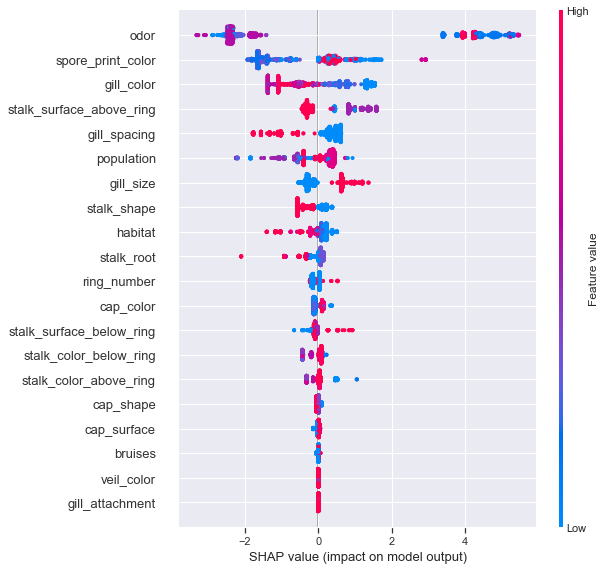

In [67]:
shap.summary_plot(shapvals_xgbc, X_test, feature_names=ftnames, class_names=['edible','poisonous'])

The summary plot is a fantastic means of succinctly explaining feature contributions, it is the first truly global insight we gain about the model. In a binary classification problem such as this, points with the greatest distance from 0 have the largest impact on model predictions and points with clear color separation have strong support.

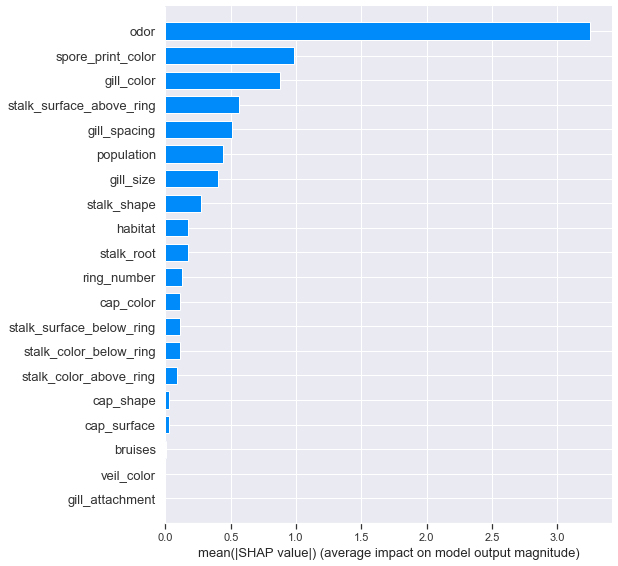

In [68]:
shap.summary_plot(shapvals_xgbc, X_test, feature_names=ftnames, class_names=['edible','poisonous'], plot_type='bar')

Setting `plot_type='bar'` provides us with the closest SHAP equivalent to a feature importance plot. Again we see `odor` dominating over other features.

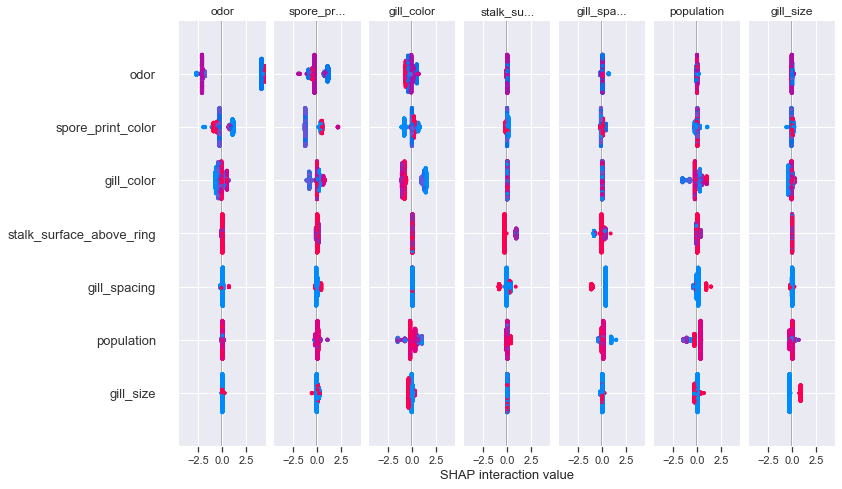

In [69]:
siv_xgbc = shap_xgbc.shap_interaction_values(X_test)
shap.summary_plot(siv_xgbc, X_test)

An interaction plot lets us see the influence of each feature on other features' shap values. The coloring scheme and 0 distance can be interpreted much in the same was as the previous summary dot plot, the difference being that this is a feature-feature interaction compared to a feature-response interaction. 

In [70]:
# Monkey patch dependence_plot (pull request accepted)
from shap.plots.dependence import *
def dependence_plot(ind, shap_values, features, feature_names=None, display_features=None,
                    interaction_index="auto",
                    color="#1E88E5", axis_color="#333333", cmap=None,
                    dot_size=16, x_jitter=0, alpha=1, title=None, xmin=None, xmax=None, ax=None, show=True):
    """ Create a SHAP dependence plot, colored by an interaction feature.
    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extenstion of the classical parital dependence plots. Vertical dispersion of the
    data points represents interaction effects. Grey ticks along the y-axis are data
    points where the feature's value was NaN.
    Parameters
    ----------
    ind : int or string
        If this is an int it is the index of the feature to plot. If this is a string it is
        either the name of the feature to plot, or it can have the form "rank(int)" to specify
        the feature with that rank (ordered by mean absolute SHAP value over all the samples).
    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features).
    features : numpy.array or pandas.DataFrame
        Matrix of feature values (# samples x # features).
    feature_names : list
        Names of the features (length # features).
    display_features : numpy.array or pandas.DataFrame
        Matrix of feature values for visual display (such as strings instead of coded values).
    interaction_index : "auto", None, int, or string
        The index of the feature used to color the plot. The name of a feature can also be passed
        as a string. If "auto" then shap.common.approximate_interactions is used to pick what
        seems to be the strongest interaction (note that to find to true stongest interaction you
        need to compute the SHAP interaction values).
        
    x_jitter : float (0 - 1)
        Adds random jitter to feature values. May increase plot readability when feature
        is discrete.
    alpha : float
        The transparency of the data points (between 0 and 1). This can be useful to the
        show density of the data points when using a large dataset.
    xmin : float or string
        Represents the lower bound of the plot's x-axis. It can be a string of the format
        "percentile(float)" to denote that percentile of the feature's value used on the x-axis.
    xmax : float or string
        Represents the upper bound of the plot's x-axis. It can be a string of the format
        "percentile(float)" to denote that percentile of the feature's value used on the x-axis.
    ax : matplotlib Axes object
         Optionally specify an existing matplotlib Axes object, into which the plot will be placed.
         In this case we do not create a Figure, otherwise we do.
    """

    if cmap is None:
        cmap = colors.red_blue
        
    # create a matplotlib figure, if `ax` hasn't been specified.
    if not ax:
        figsize = (7.5, 5) if interaction_index != ind else (6, 5)
        fig = pl.figure(figsize=figsize)
        ax = fig.gca()
    else:
        fig = ax.get_figure()

    # convert from DataFrames if we got any
    if str(type(features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = features.columns
        features = features.values
    if str(type(display_features)).endswith("'pandas.core.frame.DataFrame'>"):
        if feature_names is None:
            feature_names = display_features.columns
        display_features = display_features.values
    elif display_features is None:
        display_features = features

    if feature_names is None:
        feature_names = [labels['FEATURE'] % str(i) for i in range(shap_values.shape[1])]

    # allow vectors to be passed
    if len(shap_values.shape) == 1:
        shap_values = np.reshape(shap_values, len(shap_values), 1)
    if len(features.shape) == 1:
        features = np.reshape(features, len(features), 1)

    ind = convert_name(ind, shap_values, feature_names)
    
    # plotting SHAP interaction values
    if len(shap_values.shape) == 3 and len(ind) == 2:
        ind1 = convert_name(ind[0], shap_values, feature_names)
        ind2 = convert_name(ind[1], shap_values, feature_names)
        if ind1 == ind2:
            proj_shap_values = shap_values[:, ind2, :]
        else:
            proj_shap_values = shap_values[:, ind2, :] * 2  # off-diag values are split in half

        # TODO: remove recursion; generally the functions should be shorter for more maintainable code
        dependence_plot(
            ind1, proj_shap_values, features, feature_names=feature_names,
            interaction_index=ind2, display_features=display_features, ax=ax, show=False,
            xmin=xmin, xmax=xmax
        )
        if ind1 == ind2:
            ax.set_ylabel(labels['MAIN_EFFECT'] % feature_names[ind1])
        else:
            ax.set_ylabel(labels['INTERACTION_EFFECT'] % (feature_names[ind1], feature_names[ind2]))

        if show:
            pl.show()
        return

    assert shap_values.shape[0] == features.shape[0], \
        "'shap_values' and 'features' values must have the same number of rows!"
    assert shap_values.shape[1] == features.shape[1], \
        "'shap_values' must have the same number of columns as 'features'!"

    # get both the raw and display feature values
    oinds = np.arange(shap_values.shape[0]) # we randomize the ordering so plotting overlaps are not related to data ordering
    np.random.shuffle(oinds)
    xv = features[oinds, ind].astype(np.float64)
    xd = display_features[oinds, ind]
    s = shap_values[oinds, ind]
    if type(xd[0]) == str:
        name_map = {}
        for i in range(len(xv)):
            name_map[xd[i]] = xv[i]
        xnames = list(name_map.keys())

    # allow a single feature name to be passed alone
    if type(feature_names) == str:
        feature_names = [feature_names]
    name = feature_names[ind]

    # guess what other feature as the stongest interaction with the plotted feature
    if interaction_index == "auto":
        interaction_index = approximate_interactions(ind, shap_values, features)[0]
    interaction_index = convert_name(interaction_index, shap_values, feature_names)
    categorical_interaction = False

    # get both the raw and display color values
    color_norm = None
    if interaction_index is not None:
        cv = features[:, interaction_index]
        cd = display_features[:, interaction_index]
        clow = np.nanpercentile(cv.astype(np.float), 5)
        chigh = np.nanpercentile(cv.astype(np.float), 95)
        if type(cd[0]) == str:
            cname_map = {}
            for i in range(len(cv)):
                cname_map[cd[i]] = cv[i]
            cnames = list(cname_map.keys())
            categorical_interaction = True
        elif clow % 1 == 0 and chigh % 1 == 0 and chigh - clow < 10:
            categorical_interaction = True

        # discritize colors for categorical features
        if categorical_interaction and clow != chigh:
            clow = np.nanmin(cv.astype(np.float))
            chigh = np.nanmax(cv.astype(np.float))
            bounds = np.linspace(clow, chigh, int(chigh - clow + 2))
            color_norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N-1)

    # optionally add jitter to feature values
    if x_jitter > 0:
        if x_jitter > 1: x_jitter = 1
        xvals = xv.copy()
        if isinstance(xvals[0], float):
            xvals = xvals.astype(np.float)
            xvals = xvals[~np.isnan(xvals)]
        xvals = np.unique(xvals)
        if len(xvals) >= 2:
            smallest_diff = np.min(np.diff(np.sort(xvals)))
            jitter_amount = x_jitter * smallest_diff
            xv += (np.random.ranf(size = len(xv))*jitter_amount) - (jitter_amount/2)

    # the actual scatter plot, TODO: adapt the dot_size to the number of data points?
    xv_nan = np.isnan(xv)
    xv_notnan = np.invert(xv_nan)
    if interaction_index is not None:

        # plot the nan values in the interaction feature as grey
        cvals = features[oinds, interaction_index].astype(np.float64)
        cvals_imp = cvals.copy()
        cvals_imp[np.isnan(cvals)] = (clow + chigh) / 2.0
        cvals[cvals_imp > chigh] = chigh
        cvals[cvals_imp < clow] = clow
        p = ax.scatter(
            xv[xv_notnan], s[xv_notnan], s=dot_size, linewidth=0, c=cvals[xv_notnan],
            cmap=cmap, alpha=alpha, vmin=clow, vmax=chigh,
            norm=color_norm, rasterized=len(xv) > 500
        )
        p.set_array(cvals[xv_notnan])
    else:
        p = ax.scatter(xv, s, s=dot_size, linewidth=0, color=color,
                       alpha=alpha, rasterized=len(xv) > 500)

    if interaction_index != ind and interaction_index is not None:
        # draw the color bar
        if type(cd[0]) == str:
            tick_positions = [cname_map[n] for n in cnames]
            if len(tick_positions) == 2:
                tick_positions[0] -= 0.25
                tick_positions[1] += 0.25
            cb = pl.colorbar(p, ticks=tick_positions)
            cb.set_ticklabels(cnames)
        else:
            cb = pl.colorbar(p)

        cb.set_label(feature_names[interaction_index], size=13)
        cb.ax.tick_params(labelsize=11)
        if categorical_interaction:
            cb.ax.tick_params(length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height - 0.7) * 20)

    # handles any setting of xmax and xmin
    # note that we handle None,float, or "percentile(float)" formats
    if xmin is not None or xmax is not None:
        if type(xmin) == str and xmin.startswith("percentile"):
            xmin = np.nanpercentile(xv, float(xmin[11:-1]))
        if type(xmax) == str and xmax.startswith("percentile"):
            xmax = np.nanpercentile(xv, float(xmax[11:-1]))

        if xmin is None or xmin == np.nanmin(xv):
            xmin = np.nanmin(xv) - (xmax - np.nanmin(xv))/20
        if xmax is None or xmax == np.nanmax(xv):
            xmax = np.nanmax(xv) + (np.nanmax(xv) - xmin)/20
        
        ax.set_xlim(xmin, xmax)

    # plot any nan feature values as tick marks along the y-axis
    xlim = ax.get_xlim()
    if interaction_index is not None:
        p = ax.scatter(
            xlim[0] * np.ones(xv_nan.sum()), s[xv_nan], marker=1,
            linewidth=2, c=cvals_imp[xv_nan], cmap=cmap, alpha=alpha,
            vmin=clow, vmax=chigh
        )
        p.set_array(cvals[xv_nan])
    else:
        ax.scatter(
            xlim[0] * np.ones(xv_nan.sum()), s[xv_nan], marker=1,
            linewidth=2, color=color, alpha=alpha
        )
    ax.set_xlim(xlim)

    # make the plot more readable
    ax.set_xlabel(name, color=axis_color, fontsize=13)
    ax.set_ylabel(labels['VALUE_FOR'] % name, color=axis_color, fontsize=13)
    if title is not None:
        ax.set_title(title, color=axis_color, fontsize=13)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(color=axis_color, labelcolor=axis_color, labelsize=11)
    for spine in ax.spines.values():
        spine.set_edgecolor(axis_color)
    if type(xd[0]) == str:
        ax.set_xticks([name_map[n] for n in xnames])
        ax.set_xticklabels(xnames, dict(rotation='vertical', fontsize=11))
    if show:
        with warnings.catch_warnings(): # ignore expected matplotlib warnings
            warnings.simplefilter("ignore", RuntimeWarning)
            pl.show()

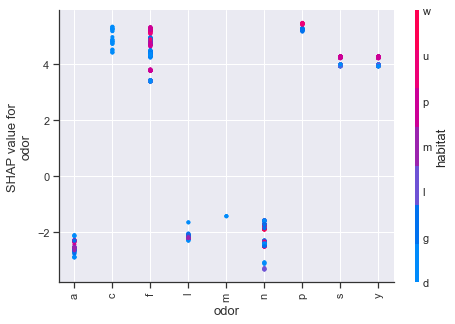

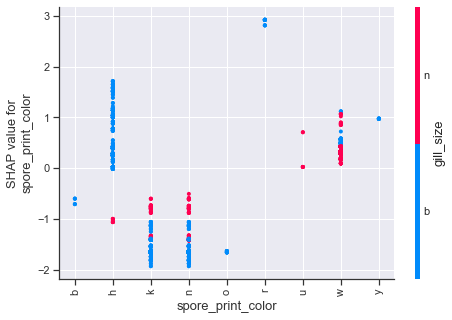

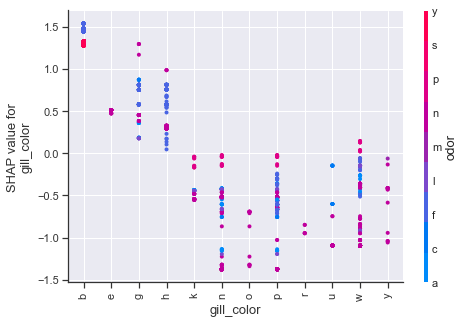

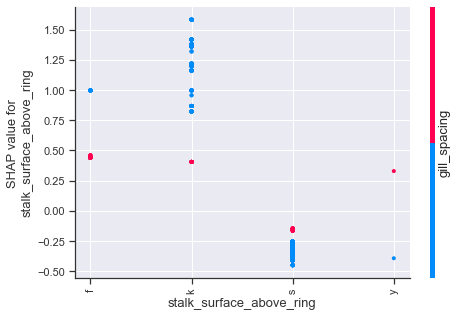

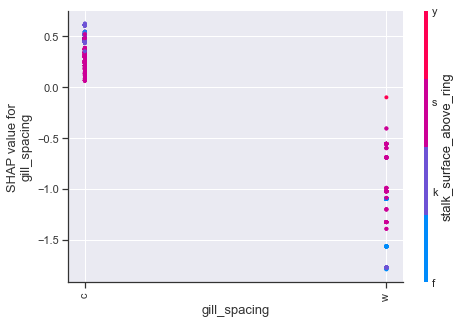

In [71]:
for i in range(5):
    dependence_plot(f'rank({i})', shapvals_xgbc, X_test, display_features=X.loc[X_test.index])

Dependence plots in SHAP can be thought of as enriched form of partial dependency plots which uses shap value interactions in place of traditional methods. Using the first plot as an example, we can see how `odor` values of `a`,`l`,`n` have a number of cases which strongly influence the shap values downward, whereas the other `odor` attributes push upwards. The color scheme for these type of plots is based on a secondary feature, so purple values should not be interpreted in the same manner as we previously have been. 

### Manual Modeling

Now that we've covered all the fancy approaches to understanding the predictive power of these models, it's time we take a step back and look at how easily this can actually be done.

In [72]:
pd.crosstab(agar.odor, [agar.toxic])

toxic     e     p
odor             
a       400     0
c         0   192
f         0  2160
l       400     0
m         0    36
n      3408   120
p         0   256
s         0   576
y         0   576

We start with an educated guess, `odor` has been consistently important throughout all of this analysis and as we previously discovered, it almost perfectly predicts every sample save for 120 cases where `odor`=`n` is poisonous.

In [73]:
def toxcor(X):
    """Helper to calculate uncertainty coefficents with the response (toxic)"""
    return X.drop('toxic',1).apply(lambda x: x.cat.codes).corrwith(X.toxic.cat.codes, method=theils_u).sort_values(ascending=False)

In [74]:
odorN = agar[agar.odor == "n"].drop('veil_type',1)

With a baseline established, now we begin to drill down. We only care about the ambiguous instances so we select only those where `odor=n`

In [75]:
toxcor(odorN)

spore_print_color           6.768442e-01
cap_color                   4.371612e-01
gill_color                  4.027649e-01
stalk_shape                 2.916187e-01
stalk_color_below_ring      2.833743e-01
habitat                     2.761553e-01
stalk_surface_below_ring    2.383585e-01
population                  2.048373e-01
cap_shape                   1.992199e-01
stalk_color_above_ring      1.688005e-01
stalk_root                  1.135320e-01
ring_number                 1.118555e-01
stalk_surface_above_ring    1.112397e-01
gill_size                   1.092590e-01
cap_surface                 7.508798e-02
veil_color                  6.435305e-02
gill_spacing                2.155632e-02
gill_attachment             1.305308e-02
bruises                     4.093762e-03
ring_type                   3.767631e-03
odor                        3.739931e-16
dtype: float64

With the reduced data, we now have new features that tell us most about our response, so let's have a look at that crosstab.

In [76]:
pd.crosstab([odorN.toxic], [odorN.spore_print_color])

spore_print_color   b   h     k     n   o   r    w   y
toxic                                                 
e                  48  48  1296  1344  48   0  576  48
p                   0   0     0     0   0  72   48   0

Following the same logic as before, we can select only samples where `odor=n` and `spore_print_color=w`

In [77]:
odorN_spcW = odorN[odorN.spore_print_color == 'w']

In [78]:
toxcor(odorN_spcW)

habitat                     0.669041
ring_number                 0.606777
gill_size                   0.606777
stalk_surface_below_ring    0.570277
cap_color                   0.543356
stalk_color_below_ring      0.528912
population                  0.305571
gill_color                  0.232560
cap_surface                 0.227199
stalk_surface_above_ring    0.184856
stalk_color_above_ring      0.174359
stalk_root                  0.125971
veil_color                  0.125133
ring_type                   0.096877
cap_shape                   0.084574
gill_spacing                0.033172
bruises                     0.030977
stalk_shape                 0.000000
gill_attachment             0.000000
odor                        0.000000
spore_print_color           0.000000
dtype: float64

In [79]:
pd.crosstab([odorN_spcW.toxic],[odorN_spcW.habitat])

habitat   d    g   l   p    w
toxic                        
e         8  288  48  40  192
p        32    0  16   0    0

Now we have two ambiguous features, so filter again and include the two `habitat` values of interest.

In [80]:
odorN_spcW_habLD = odorN_spcW[odorN_spcW.habitat.isin(['l','d'])]

In [81]:
toxcor(odorN_spcW_habLD)

stalk_root                  0.664063
stalk_surface_above_ring    0.594799
cap_color                   0.574353
stalk_color_below_ring      0.468665
stalk_surface_below_ring    0.448007
population                  0.249910
gill_spacing                0.219754
habitat                     0.219754
stalk_color_above_ring      0.155288
cap_shape                   0.133864
veil_color                  0.091625
bruises                     0.091625
cap_surface                 0.084183
ring_number                 0.072962
gill_size                   0.072962
gill_color                  0.044391
ring_type                   0.000782
stalk_shape                 0.000000
gill_attachment             0.000000
odor                        0.000000
spore_print_color           0.000000
dtype: float64

In [82]:
pd.crosstab([odorN_spcW_habLD.toxic], [odorN_spcW_habLD.stalk_root], )

stalk_root   ?   b  c
toxic                
e            0  56  0
p           32   8  8

In [83]:
odorN_spcW_habLD_stkB = odorN_spcW_habLD[odorN_spcW_habLD.stalk_root == 'b']

In [84]:
toxcor(odorN_spcW_habLD_stkB)

cap_color                   1.000000e+00
bruises                     1.000000e+00
stalk_color_below_ring      1.000000e+00
population                  1.000000e+00
ring_type                   5.400729e-01
cap_surface                 5.000000e-01
cap_shape                   3.457588e-01
stalk_surface_below_ring    2.537425e-01
stalk_surface_above_ring    2.537425e-01
gill_size                   4.755786e-02
gill_spacing                4.755786e-02
habitat                     4.755786e-02
stalk_color_above_ring      4.755786e-02
ring_number                 4.755786e-02
gill_color                  1.473343e-16
stalk_shape                 1.473343e-16
gill_attachment             1.473343e-16
odor                        1.473343e-16
veil_color                  1.473343e-16
spore_print_color           1.473343e-16
stalk_root                  1.473343e-16
dtype: float64

We've hit the bottom of the tree, any one of `cap_color`, `bruises`, `stalk_color_below_ring`, or `population` can be used as our final filter.

In [85]:
pd.crosstab([odorN_spcW_habLD_stkB.toxic], [odorN_spcW_habLD_stkB.cap_color])

cap_color   c   n  w
toxic               
e          24  32  0
p           0   0  8

Now we can put this logic into a function and verify that it maintains perfect predictive power.

In [86]:
def logic_tree(X):
    preds = []
    for i,r in X.iterrows():
        if r.odor in ['a','l']:
            preds.append(0)
        elif r.odor == 'n':
            if r.spore_print_color == 'r':
                preds.append(1)
            elif r.spore_print_color == 'w':
                if r.habitat not in ['l','d']:
                    preds.append(0)
                else:
                    if r.stalk_root != 'b':
                        preds.append(1)
                    else:
                        preds.append(1 if r.cap_color == 'w' else 0)
            else: 
                preds.append(0) # spore_print_color
        else: 
            preds.append(1) # odor
    return preds

In [2]:
HTML(url='https://gist.githubusercontent.com/Rypo/1a1c539685d42e80be80d0ec63ff80db/raw/085066fae2f996c7d92be81f4fc9dec1b5701dbe/agarflowchart.svg')

Here's a sketch of the entire logical path. It's certainly not the only path to perfect classification, but it is likely one of the shortest. It's designed for humans to easily understand, with each branch having either a verdict (edible/poisonous) or a 'continue on' path in a flowchart type fashion.

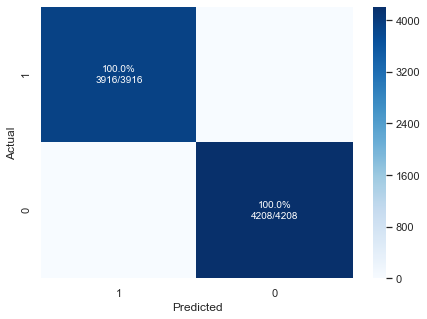

In [87]:
ltpreds = logic_tree(X)
pplot_cm(y_enc, ltpreds, cmap="Blues")

With this simple flowchart, we achieve perfect classification.

So, why is it that neither of our "smallest" decision trees found this path?

As it turns out, the method we chose for categorical encoding the values had a large effect on how optimized any decision could be. Since it is forced to make simple gt/lt style splits, decision paths were not always optimal. For example, `odor` was encoded in such a way that 1,2,3 were mapped to `a`,`l`,`n` (values that mapped almost entirely to edible), however, 0 was mapped to `p`, a value always poisonous. At best, the tree could attempt a split `odor`<=3.5 and correctly account for most cases immediately, but then would need to go back and account for 0 and the remaining poisonous values in `n` with additional leaf nodes. 

## Conclusions

In this notebook we used a Random Forest Classifier and XGBClassifier to attempt to determine if a particular mushroom was toxic when eaten based on its physical characteristics. 

The data was converted into the simplest possible numeric representation and a basic one-hot encoding. Using just default hyperparameters, we were able to obtain four perfect classifiers. To identify the root cause of the predictive power, we used permutation importance, LIME, and SHAP to gain model insights. Finally, we showed how to create a perfect classifier using no machine learning at all.

----

So what is the value in doing something like this? Well, if this were a real dataset, this information could potentially be put into a field guide for mushroom hunting, but it's fabricated so we'll take this opportunity to derive value the analysis itself. It demonstrates that you may not always need to jump right into machine learning algorithms to reach a desired solution. 

We were capped at 100% for our models, so we couldn't try and push the score any higher to get a better predictor, so instead we set our goal to find the simplest possible perfect predictor. Now, with real world dataset the odds of having a perfect classifier are about the same as that decision path we made being published in a mushrooming safety handbook, but the sentiment holds true regardless of the predictive ceiling value. 

With deeper understanding of data comes better models, better understanding of models gives more insight into the data, it's a positive feedback loop and it is always applicable.

**Future work**:<br>
The decision path we arrived at was not explicitly proven to be optimal, we could potentially implement a shortest path type algorithm to search for this combination. One section that was omitted from this analysis demonstrated how a perfect classifier could be made using as little as 3% of the dataset (~240 samples), theoretically this should be able to be reduced even further knowing now what we do about about the interaction between `odor` and the response.

### References

#### Code:
1. https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
2. https://xgboost.readthedocs.io/en/latest/get_started.html
3. https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
4. https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html
5. https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

#### Text:
1. https://archive.ics.uci.edu/ml/datasets/mushroom
2. https://www.kaggle.com/uciml/mushroom-classification/home
3. https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime
4. https://christophm.github.io/interpretable-ml-book/shapley.html

#### Other:
1. http://pbpython.com/categorical-encoding.html
2. http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
3. https://xgboost.readthedocs.io/en/latest/python/python_api.html
4. https://github.com/slundberg/shap
5. https://shap.readthedocs.io/en/latest/
6. https://github.com/slundberg/shap/issues/367
7. https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/
8. http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html#Feature-Contributions